# Packages

In [1]:
%%capture
!pip install rdkit

In [2]:
# Basic data manipulation
import numpy as np
import pandas as pd
import random

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import Descriptors

# XG boost
import xgboost as xgb

# Sklearn for downstream prediction
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Pytorch for finetuning BERT model
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# Load transformer model
from transformers import AutoModelForMaskedLM, AutoTokenizer, AutoModel, AutoModelForSequenceClassification

# Dataset and Pretrained Model

* The training dataset `train.csv` is loaded to `df_train`.
* The transformer model `ChemBerta` is available in Kaggle (https://www.kaggle.com/code/michaelrowen/opp2025-chemberta-pre-trained-base).

In [3]:
df_train = pd.read_csv('/kaggle/input/melting-point/train.csv')
df_test = pd.read_csv('/kaggle/input/melting-point/test.csv')
chemberta_model = '/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM'

+ The dataset is split into 80/20 for training and validation.

In [4]:
seed = 20251017
torch.manual_seed(seed)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=seed)

+ Standardization $(y_i-\bar{y})/s$ is applied to the target, melting points `Tm`.
+ The standardized target values are denoted by `TmS`.

In [5]:
scaler = StandardScaler()
scaler.fit(df_train[['Tm']]) # pass in 2D array
std = scaler.var_[0]**0.5 # estimate of s

df_train['TmS'] = scaler.transform(df_train[['Tm']]).flatten() # convert back to 1D array 
df_val['TmS'] = scaler.transform(df_val[['Tm']]).flatten()

+ Define the data handler for fine-tuning ChemBerta with pytorch.

In [6]:
class ChemDataset(Dataset):  
    def __init__(self, df, tokenizer, max_length=128):  
        self.smiles = df['SMILES'].tolist()  
        self.labels = df['TmS'].tolist()  
        self.tokenizer = tokenizer  
        self.max_length = max_length  
  
    def __len__(self):  
        return len(self.labels)  
  
    def __getitem__(self, idx):  
        encoding = self.tokenizer(  
            self.smiles[idx],  
            truncation=True,  
            padding='max_length',  
            max_length=self.max_length,  
            return_tensors='pt'  
        )  
        item = {key: val.squeeze(0) for key, val in encoding.items()}  
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  
        return item  

+ Define the transformer model ChemBerta.
+ A regression head is added on top of the transformer model.

In [7]:
# Model retrieved from https://www.kaggle.com/code/michaelrowen/opp2025-chemberta-pre-trained-base
class BERTEmbedder:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(  
            model_name,
            num_labels=1,  
            problem_type='regression' # Regression task  
        )  
        self.model.eval()

# Finetuning ChemBERTA

+ Load the transfomer model and define data handlers for training and validation sets, respectively.

In [8]:
# Training configuration
chemberta = BERTEmbedder(model_name=chemberta_model)
optimizer = AdamW(chemberta.model.parameters(), lr=1e-4) # lr set by experiment
loss_fn = nn.L1Loss() # Since reduce = mean, L1Loss measures MAE
n_epochs = 30

# Data handler
dataset_train = ChemDataset(df_train, chemberta.tokenizer)
dataset_val = ChemDataset(df_val, chemberta.tokenizer)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True) # batch_size set by experiment
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=True) # batch_size set by experiment

2025-11-03 16:57:20.771579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762189040.998868      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762189041.069145      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+ Move the model to GPU on Kaggle platform and start training.

In [9]:
# Enable GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
chemberta.model.to(device)

train_loss_list = []
val_loss_list = []
# Training cycle
for epoch in range(n_epochs):
    chemberta.model.train()
    epoch_train_size = 0
    epoch_val_size = 0
    epoch_train_loss = 0
    epoch_val_loss = 0

    # evaluate training set
    for batch in dataloader_train:
        # forward pass
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}  
        labels = batch['labels'].to(device).unsqueeze(1)  # shape [B,1]  
        outputs = chemberta.model(**inputs).logits  # shape [B,1] 
        loss = loss_fn(outputs, labels)  

        # backward pass
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        # update epoch loss
        epoch_train_loss += loss.item() * dataloader_train.batch_size * std
        epoch_train_size += dataloader_train.batch_size
    
    # evaluate validation set
    with torch.no_grad():
        for batch in dataloader_val:
            # forward pass
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}  
            labels = batch['labels'].to(device).unsqueeze(1)  # shape [B,1]  
            outputs = chemberta.model(**inputs).logits  # shape [B,1] 
            loss = loss_fn(outputs, labels)  

            # update epoch loss
            epoch_val_loss += loss.item() * dataloader_val.batch_size * std
            epoch_val_size += dataloader_val.batch_size

    # compute loss per epoch
    avg_train_loss = epoch_train_loss/epoch_train_size
    avg_val_loss = epoch_val_loss/epoch_val_size

    # save model with the lowest validation loss
    if len(val_loss_list) > 0 and avg_val_loss < np.min(val_loss_list):
        torch.save(chemberta.model.state_dict(), '/kaggle/working/weights.pth')
        
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    print(f"Epoch {epoch + 1} done, training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}")  

Epoch 1 done, training loss: 49.3997, validation loss: 43.1056
Epoch 2 done, training loss: 39.6177, validation loss: 39.6687
Epoch 3 done, training loss: 35.7749, validation loss: 38.3034
Epoch 4 done, training loss: 34.0615, validation loss: 38.3894
Epoch 5 done, training loss: 33.1421, validation loss: 35.8712
Epoch 6 done, training loss: 31.0938, validation loss: 36.1660
Epoch 7 done, training loss: 30.6721, validation loss: 35.9603
Epoch 8 done, training loss: 30.1994, validation loss: 35.7469
Epoch 9 done, training loss: 29.6961, validation loss: 34.8828
Epoch 10 done, training loss: 29.1728, validation loss: 35.1235
Epoch 11 done, training loss: 28.9291, validation loss: 35.2323
Epoch 12 done, training loss: 28.1107, validation loss: 35.7300
Epoch 13 done, training loss: 26.7907, validation loss: 36.7645
Epoch 14 done, training loss: 26.6994, validation loss: 34.6290
Epoch 15 done, training loss: 26.6998, validation loss: 35.4138
Epoch 16 done, training loss: 25.3843, validation

In [10]:
# Load the best model
chemberta.model.eval()
chemberta.model.to('cpu')
chemberta.model.load_state_dict(torch.load('/kaggle/working/weights.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

+ The validation loss seems to be converged after 15 epochs. 

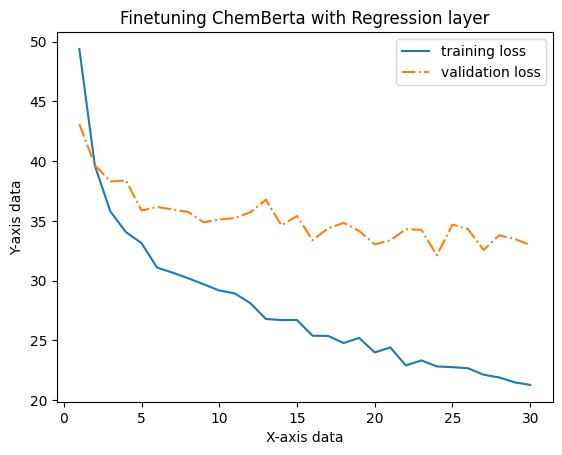

In [11]:
import matplotlib.pyplot as plt
plt.plot([i + 1 for i in range(n_epochs)], train_loss_list, label ='training loss')
plt.plot([i + 1 for i in range(n_epochs)], val_loss_list, '-.', label ='validation loss')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('Finetuning ChemBerta with Regression layer')
plt.show()

# Generate Features

In [12]:
def extract_chembert_embeddings(smiles_list, embedder, n_data):
    n_latent = 384
    embeddings = np.zeros((n_data, n_latent))
    
    for i, smiles in enumerate(smiles_list):
        with torch.no_grad():
            # Getting the model output
            encoded_input = embedder.tokenizer(smiles, return_tensors='pt', padding=True, truncation=True)
            model_output = embedder.model(**encoded_input, output_hidden_states=True)
            # embeddings[i, :] = model_output.logits.numpy()
            
            # Getting the CLS token from model output
            embedding = model_output.hidden_states[3][:, 0, :]
            embeddings[i, :] = embedding.numpy()
    
    return pd.DataFrame(embeddings, columns=[f'embedding_{i+1}' for i in range(n_latent)])

In [13]:
# Code retrieved from https://www.kaggle.com/code/aliffaagnur/single-lightgbm-optuna/notebook
def extract_all_descriptors(smiles_list):

    # GET ALL DESCRIPTORS
    descriptor_list = Descriptors._descList    # --> THESE WILL RETURN LIST OF TUPLE
    descriptors = [desc[0] for desc in descriptor_list]

    print(f'There Are {len(descriptor_list)} Descriptor Features')

    # EXTRACT ALL DESCRIPTORS FROM SMILES FEATURES
    result = []
    for smiles in smiles_list:

        mol = Chem.MolFromSmiles(smiles)

        # IF MOLECOLE IS INVALID
        if mol is None:
            row = {name : None for name, func in descriptor_list}
        else:
            # CREATE DESCRIPTORS FEATURES
            row = {name: func(mol) for name, func in descriptor_list}

        result.append(row)

    # MERGE DATA WITH EXTRACTED FEATURES
    return pd.DataFrame(result)

In [14]:
# Generate features for training set
embeddings_train = extract_chembert_embeddings(df_train['SMILES'], chemberta, df_train.shape[0])
molecular_features_train = extract_all_descriptors(df_train['SMILES'])

# Generate features for validation set
embeddings_val = extract_chembert_embeddings(df_val['SMILES'], chemberta, df_val.shape[0])
molecular_features_val = extract_all_descriptors(df_val['SMILES'])

There Are 217 Descriptor Features
There Are 217 Descriptor Features


In [15]:
# Dataset size
print('Training set')
print(embeddings_train.shape, type(embeddings_train))
print(molecular_features_train.shape, type(molecular_features_train))

print('Valiodation set')
print(embeddings_val.shape, type(embeddings_val))
print(molecular_features_val.shape, type(molecular_features_val))

Training set
(2129, 384) <class 'pandas.core.frame.DataFrame'>
(2129, 217) <class 'pandas.core.frame.DataFrame'>
Valiodation set
(533, 384) <class 'pandas.core.frame.DataFrame'>
(533, 217) <class 'pandas.core.frame.DataFrame'>


# Downstream Prediction Task

## Data Preparation
+ Prepare training and validation datasets for downstream tasks, `df_ttl_train` and `df_ttl_val`.
+ For each dataset, they are split into input and output `X` and `y`.

In [16]:
# Dataset for sklearn - Training set
df_ttl_train = pd.concat([
    df_train.reset_index(drop=True), 
    embeddings_train, 
    molecular_features_train
], axis=1)
y_train = df_ttl_train['TmS']
X_train = df_ttl_train.drop(df_train.columns, axis=1)
#X_train = df_ttl_train.drop(['id', 'Tm', 'TmS', 'SMILES'], axis=1)
X_train.columns = [str(colname) for colname in X_train.columns]

# Dataset for sklearn - Validation set
df_ttl_val = pd.concat([
    df_val.reset_index(drop=True), 
    embeddings_val, 
    molecular_features_val
], axis=1)
y_val = df_ttl_val['TmS']
X_val = df_ttl_val.drop(df_val.columns, axis=1)
#X_val = df_ttl_val.drop(['id', 'Tm', 'TmS', 'SMILES'], axis=1)
X_val.columns = [str(colname) for colname in X_val.columns]

## Feature Selection

In [17]:
drop_columns = [] # hold the column names to be dropped

# Count number of unique elements in each feature
for column in X_train.columns:
    nunique = X_train[column].nunique()
    if nunique < X_train.shape[0] * 0.1: # threshold 10%, just guess
        drop_columns.append(column)

# Show results
print(f'Number of dropped columns: {len(drop_columns)}')
X_train.drop(drop_columns, axis=1, inplace=True)
X_val.drop(drop_columns, axis=1, inplace=True)

Number of dropped columns: 149


## Extreme Gradient Boosting

In [18]:
param_grid = {
    # 1. LEARNING RATE AND TREE STRUCTURE
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Also known as eta
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'n_estimators': [100, 200, 300, 500, 1000],
    
    # 2. REGULARIZATION PARAMETERS (Crucial for preventing overfitting)
    'reg_alpha': [0, 0.1, 0.5, 1.0, 5.0],  # L1 regularization
    'reg_lambda': [1, 1.5, 2.0, 3.0, 5.0],  # L2 regularization
    'gamma': [0, 0.1, 0.2, 0.5, 1.0],  # Minimum loss reduction
    
    # 3. SUBSAMPLING PARAMETERS
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Row sampling
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Column sampling
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],  # Per-level column sampling
    'colsample_bynode': [0.6, 0.7, 0.8, 0.9, 1.0],  # Per-node column sampling
    
    # 4. LOSS FUNCTION SPECIFIC
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of instance weight needed in child
}

max_iter = 1000

In [19]:
def sample_params():
    param_temp = {key: None for key in param_grid.keys()}
    for key in param_grid.keys():
        param_temp[key] = random.sample(param_grid[key], 1)[0]
    return param_temp

In [20]:
# Define hyperparameter grid for optimization  
mae_scores = []
for i in range(max_iter):
    param = sample_params()
    model_xgb = xgb.XGBRegressor(random_state=seed, objective='reg:squarederror', device='cuda', **param)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_val)
    mae_score = mean_absolute_error(y_val, y_pred) * std
    mae_scores.append({**param, 'mae_score': mae_score})
    print(i, mae_score)
                    
df_downstream = pd.DataFrame(mae_scores) 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:59:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0 31.34645118756944
1 32.41773995158433
2 30.2531528420192
3 31.051808708304456
4 30.934589532568864
5 40.26461211009547
6 32.26537903402722
7 31.7053839541193
8 41.734707451656156
9 31.993608239464013
10 32.296121665811846
11 32.690004460233304
12 31.66587507391143
13 31.29859851535812
14 31.0523068252887
15 31.55194786535711
16 31.080954077146377
17 30.400439396688668
18 29.96949528064012
19 30.9541691460025
20 30.44989813309804
21 30.680409785274957
22 30.944248081834463
23 30.311360383859405
24 32.41524291069347
25 31.16407299152068
26 31.024217710318002
27 32.37247822134079
28 30.82222726261238
29 31.283918600902066
30 30.988796732368492
31 31.443549369792706
32 30.852424244940355
33 31.768251842790153
34 31.333362870574096
35 31.97006869287717
36 32.56975863618413
37 31.0896037738214
38 31.83035259984113
39 31.22230209755292
40 30.716293146934316
41 30.88625900089338
42 30.329973142821043
43 30.87602534215071
44 32.311260343949634
45 29.90355469295281
46 30.478536921564608
47 30.

In [21]:
df_downstream.sort_values(by='mae_score', inplace=True)
df_downstream.head()

,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree,colsample_bylevel,colsample_bynode,min_child_weight,mae_score
918,0.05,4,1000,1.0,1.0,0.0,0.6,0.6,0.8,1.0,3,29.320198
721,0.05,5,500,0.1,3.0,0.0,0.9,0.8,0.7,1.0,5,29.485592
512,0.10,7,500,0.5,5.0,0.0,0.6,0.9,1.0,0.8,7,29.506503
273,0.05,6,1000,0.0,3.0,0.1,0.6,0.9,0.7,0.9,7,29.562368
648,0.10,5,300,0.0,2.0,0.0,0.8,0.7,0.8,0.9,5,29.632632


In [22]:
# Retrieve the best model parameters
best_model_config = df_downstream.reset_index().\
    nsmallest(1, 'mae_score').\
    drop('mae_score', axis=1).\
    to_dict(orient='index')[0]

del best_model_config['index']

# Train the downstream model with the best parameters
best_model = xgb.XGBRegressor(random_state=seed, objective='reg:squarederror', **best_model_config)
X_cat = pd.concat([X_train, X_val], axis=0)
y_cat = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_cat, y_cat)

print(X_cat.shape)
print(y_cat.shape)

(2662, 452)
(2662,)


# Submission

In [23]:
# Generate features for the test set
embeddings_test = extract_chembert_embeddings(df_test['SMILES'], chemberta, df_test.shape[0])
molecular_features_test = extract_all_descriptors(df_test['SMILES'])

# Prepare dataset for downstream regression tasks
df_ttl_test = pd.concat([
    df_test.reset_index(drop=True), 
    embeddings_test, 
    molecular_features_test
], axis=1)


X_test = df_ttl_test.drop(df_test.columns, axis=1)
X_test.columns = [str(colname) for colname in X_test.columns]
X_test.drop(drop_columns, axis=1, inplace=True)

y_pred = scaler.inverse_transform( # back transform to raw target
    np.expand_dims(best_model.predict(X_test), axis=1) # convert to 2D array by adding an extra dimension
)

There Are 217 Descriptor Features


In [24]:
df_out = pd.DataFrame({'id': df_ttl_test['id'],'Tm': y_pred.flatten()})
df_out.to_csv('./submission.csv', index=False)